<a href="https://colab.research.google.com/github/yohanesnuwara/geostatistics/blob/main/project_notebooks/EDA_LWD_openhole_volve_well_15_9_F_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d 

plt.style.use("classic")

!pip install lasio
import lasio
import missingno as msno
import plotly.express as px

In [ ]:
!git clone https://github.com/yohanesnuwara/geostatistics

Cloning into 'geostatistics'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 199 (delta 19), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (199/199), 31.65 MiB | 6.99 MiB/s, done.
Resolving deltas: 100% (78/78), done.


## LWD data

Copying script from the previous notebook, "EDA_realtime_volve_well_15_9_F-15.ipynb". There are two files, merged into one. 

In [ ]:
# Realtime data
LAS_file1 = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_1~LF1~FRM1.las"
LAS_file2 = "/content/geostatistics/data/volve-realtime/well_15_9_F-15/WL_RAW_CAL-DEN-ELEM-GR-NEU-REMP_MWD_2~LF1~FRM1.las"

mwd1 = lasio.read(LAS_file1)
mwd2 = lasio.read(LAS_file2)

# Convert LAS to dataframe
mwd1_df = mwd1.df().reset_index()
mwd2_df = mwd2.df().reset_index()

# Selected LWD logs. Special here is Bit size (BS_ARC)
mwd_lognames = ["TDEP", "GRMA", "BCAV", "WCLA", "WCAR", "WQFM", 
                "RHOB", "BPHI", "PEF", "BS_ARC"]

# Select subset dataframe
mwd1_df = mwd1_df[mwd_lognames]
mwd2_df = mwd2_df[mwd_lognames]

# Merging dataframes
mwd_df = pd.concat([mwd1_df, mwd2_df], axis=0)

# Converting ft to m
mwd_df["TDEP"] = mwd_df["TDEP"] / 3.281

# Converting NPHI in % to v/v
mwd_df["BPHI"] = mwd_df["BPHI"] / 100

mwd_df.head()

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC
0,2524.839988,29.6139,15.1446,72.9994,1.68169,23.4180,2.03128,0.492305,60.3361,8.5
1,2524.992380,30.2355,15.1291,74.1390,0.00000,23.2063,2.00606,0.463261,61.3447,8.5
2,2525.144773,31.8206,14.0747,74.7036,0.00000,21.3821,2.01147,0.453416,58.5946,8.5
3,2525.297165,30.4889,15.2500,73.9052,0.00000,21.1337,2.00483,0.498758,60.2625,8.5
4,2525.449558,30.0100,15.2500,70.8281,0.00000,22.4436,2.04901,0.524629,60.5356,8.5


In [ ]:
mwd_df.describe()

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC
count,11383.000000,11028.000000,11008.000000,10872.000000,10872.000000,10872.000000,11010.000000,10475.000000,11010.000000,10990.0
mean,3334.337576,40.143142,8.656713,14.319751,35.994992,48.730271,2.465209,17.745643,8.944052,8.5
std,437.167645,54.749415,0.460286,17.648603,35.650104,30.375033,0.163013,10.109080,10.049985,0.0
min,2524.839988,4.588600,8.375790,0.000000,0.000000,0.000000,1.537190,2.849170,3.178270,8.5
25%,2958.473331,13.318575,8.544518,2.901600,0.000000,21.572675,2.330840,9.164395,5.928580,8.5
50%,3392.106370,29.298050,8.605040,8.063390,23.437450,45.685700,2.532880,14.337400,7.067555,8.5
75%,3662.755562,44.605375,8.680392,17.291575,73.041500,77.279025,2.599480,26.467700,7.664150,8.5
max,4089.454739,1065.610000,15.250000,75.342900,100.000000,100.000000,3.503930,94.503100,94.352300,8.5


## Openhole data

In [ ]:
# Open hole data 
LAS_file3 = "/content/geostatistics/data/volve-openhole/well_15_9_F-15/WLC_PETRO_COMPUTED_INPUT_1~LF1~FRM1.las"

oh = lasio.read(LAS_file3)
oh_df = oh.df().reset_index()

# Converting ft to m
oh_df["DEPTH"] = oh_df["DEPTH"] / 3.281

oh_df.head()

,DEPTH,CALI,DRHB,DRHO,DRHU,DT,GR,NPHI,PEF,RD,RHOB,ROBB,ROBU,RS,RT
0,0.000000,8.88,NaN,NaN,NaN,NaN,NaN,0.615014,69.4872,NaN,1.7783,NaN,NaN,NaN,NaN
1,0.152393,8.88,NaN,NaN,NaN,NaN,NaN,0.615014,69.4872,NaN,1.7783,NaN,NaN,NaN,NaN
2,0.304785,8.88,NaN,NaN,NaN,NaN,NaN,0.615014,69.4872,NaN,1.7783,NaN,NaN,NaN,NaN
3,0.457178,8.88,NaN,NaN,NaN,NaN,NaN,0.615014,69.4872,NaN,1.7783,NaN,NaN,NaN,NaN
4,0.609570,8.88,NaN,NaN,NaN,NaN,NaN,0.615014,69.4872,NaN,1.7783,NaN,NaN,NaN,NaN


In [ ]:
oh_df.describe()

,DEPTH,CALI,DRHB,DRHO,DRHU,DT,GR,NPHI,PEF,RD,RHOB,ROBB,ROBU,RS,RT
count,26838.000000,23787.000000,3332.000000,10760.000000,3332.000000,10016.000000,25815.000000,26838.000000,23788.000000,17876.000000,26838.000000,3332.000000,3332.000000,17876.000000,17876.000000
mean,2044.879702,8.774959,0.055184,-0.042006,0.170733,78.810932,65.895394,0.449654,49.911437,2.896364,2.041154,2.503533,2.501931,33.634406,40.461305
std,1180.677892,0.162259,0.066261,0.281770,0.074943,18.015994,51.493693,0.222738,29.780353,9.177969,0.345733,0.136534,0.143181,389.593561,430.475347
min,0.000000,8.307200,-0.091700,-2.695850,-0.031100,52.269000,3.880000,-4.925540,2.020500,0.100000,0.944600,1.554800,1.458000,0.100000,0.100000
25%,1022.439805,8.589750,0.020700,0.002983,0.140900,64.063775,23.294450,0.226282,5.735600,0.814300,1.778300,2.385750,2.388450,0.644650,0.645875
50%,2044.879610,8.880000,0.030800,0.014773,0.182950,73.096700,62.120000,0.615014,69.487200,1.158750,1.778300,2.559450,2.557700,0.990000,1.001900
75%,3067.319720,8.880000,0.044600,0.027600,0.219200,90.138825,97.059000,0.615014,69.487200,3.129450,2.394775,2.600500,2.604100,3.082925,3.257675
max,4089.759525,9.957900,0.348600,0.348600,0.455700,132.337000,1068.510000,0.804117,195.247000,200.000000,2.981000,2.981000,3.042300,5000.000000,5000.000000


## Merge Openhole to LWD data by interpolation

I have shown interpolation method in the previous notebook. I'll now use Scipy cubic interpolation that's found to be more accurate than Numpy linear interpolation. 

In [ ]:
def interpolate(df_data, df_new, x_data, y_data, x_new):
  xd, yd = df_data[x_data], df_data[y_data]
  f = interp1d(xd, yd)
  xn = df_new[x_new]
  return f(xn)

lognames_data = ["CALI",	"DT",	"GR",	"NPHI",	"PEF",	"RD",	"RHOB"]
lognames_new = ["CALI_OH",	"DT_OH",	"GR_OH",	"NPHI_OH",	"PEF_OH",	"RD_OH",	"RHOB_OH"]

new_logs = []
for i in lognames_data:
  _ = interpolate(oh_df, mwd_df, x_data="DEPTH", y_data=i, x_new="TDEP")
  new_logs.append(_)

# Merge the result to LWD dataframe
for i in range(len(lognames_new)):
  mwd_df[lognames_new[i]] = new_logs[i]

mwd_df.head()

,TDEP,GRMA,BCAV,WCLA,WCAR,WQFM,RHOB,BPHI,PEF,BS_ARC,CALI_OH,DT_OH,GR_OH,NPHI_OH,PEF_OH,RD_OH,RHOB_OH
0,2524.839988,29.6139,15.1446,72.9994,1.68169,23.4180,2.03128,0.492305,60.3361,8.5,8.6070,NaN,28.4335,0.553489,60.0329,0.1472,2.0504
1,2524.992380,30.2355,15.1291,74.1390,0.00000,23.2063,2.00606,0.463261,61.3447,8.5,8.6114,NaN,29.0303,0.500800,56.4978,0.1000,2.0504
2,2525.144773,31.8206,14.0747,74.7036,0.00000,21.3821,2.01147,0.453416,58.5946,8.5,8.5397,NaN,30.5522,0.514001,51.4250,0.8424,2.1281
3,2525.297165,30.4889,15.2500,73.9052,0.00000,21.1337,2.00483,0.498758,60.2625,8.5,8.4808,NaN,29.2736,0.543459,55.8778,0.3764,2.0002
4,2525.449558,30.0100,15.2500,70.8281,0.00000,22.4436,2.04901,0.524629,60.5356,8.5,8.5531,NaN,28.8138,0.556054,64.8134,0.1000,1.9213


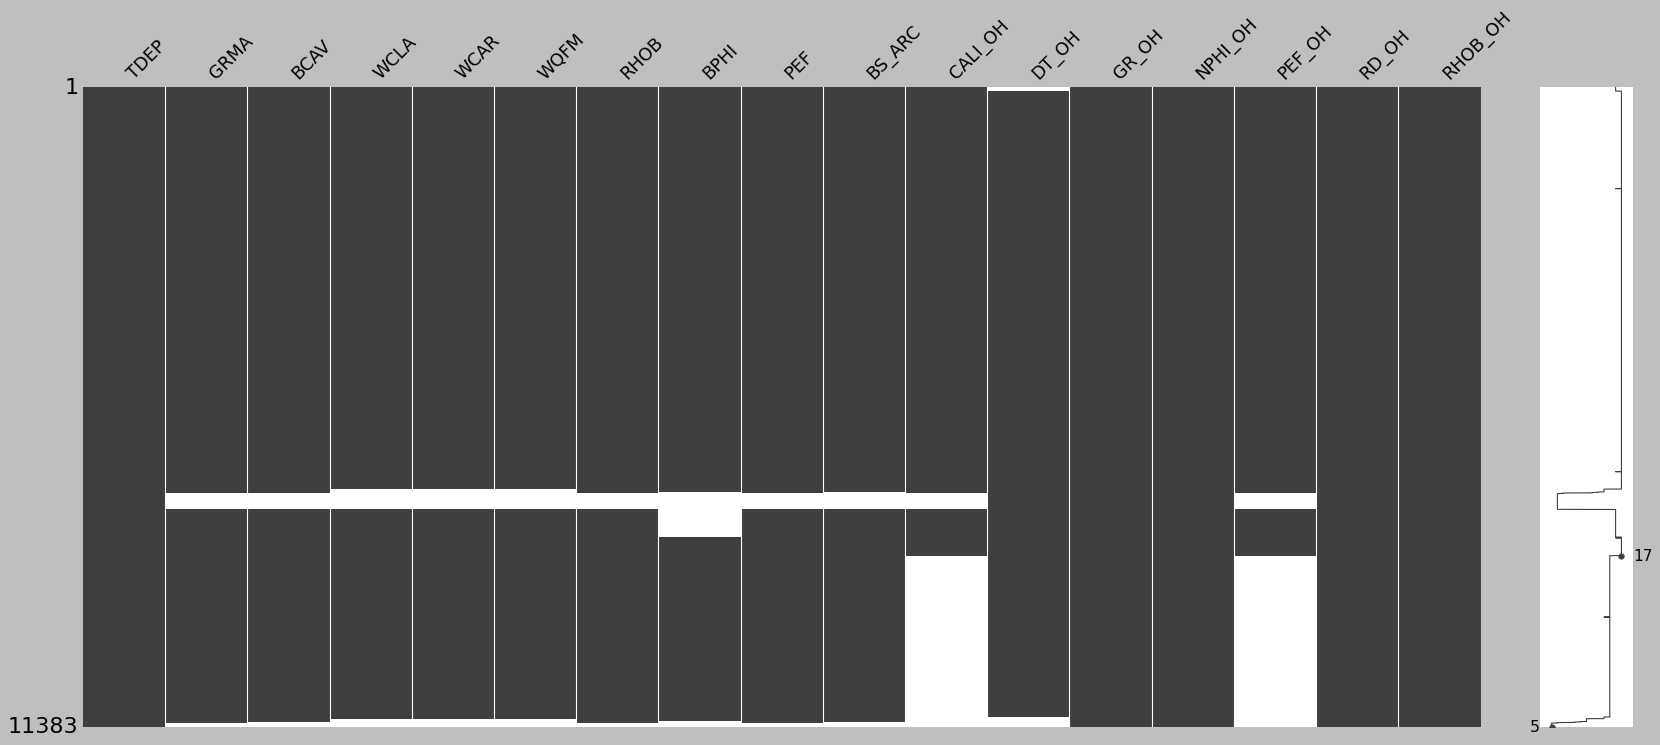

In [ ]:
msno.matrix(mwd_df)
plt.show()

## Scatter plot between openhole and LWD

I make a scatter plot below to compare measurements between openhole and LWD. As we see below, only GR fits perfectly on the 1:1 line. 

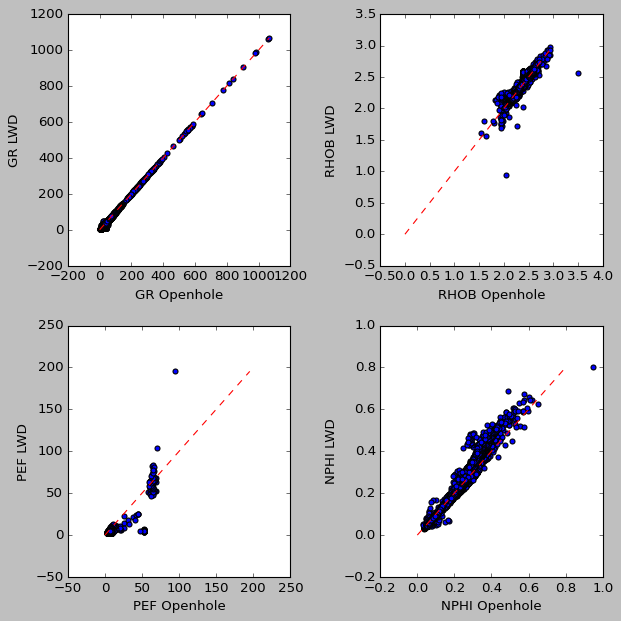

In [ ]:
# LWD
lwd_rec_name = ["GRMA", "RHOB", "PEF", "BPHI"]
lwd_recs = []
for i in lwd_rec_name:
  _ = mwd_df[i].values
  lwd_recs.append(_)

# Openhole
oh_rec_name = ["GR_OH", "RHOB_OH", "PEF_OH", "NPHI_OH"]
oh_recs = []
for i in oh_rec_name:
  _ = mwd_df[i].values
  oh_recs.append(_)

# Scatter plot
plt.figure(figsize=(8,8))

xlabels = ["GR Openhole", "RHOB Openhole", "PEF Openhole", "NPHI Openhole"]
ylabels = ["GR LWD", "RHOB LWD", "PEF LWD", "NPHI LWD"]

for i in range(len(lwd_rec_name)):
  plt.subplot(2,2,i+1)
  plt.scatter(lwd_recs[i], oh_recs[i])

  # Plot 1:1 line
  x = [0, max(oh_recs[i])]
  plt.plot(x, x, '--', color='red') 

  plt.xlabel(xlabels[i])
  plt.ylabel(ylabels[i])

plt.tight_layout(1.3)
plt.show()

## Adding formation tops and facies

## Percent clay, quartz, and carbonates

Actually there are not only WCLA (clay), WCAR (carb), & WQFM (qtz), but also siderite, pyrite, anhydrite, etc. So, not all WCLA+WCAR+WQFM sums up to 1. 

To assume a composition of ONLY clay, carb, & qtz, I need to make correction, e.g. for clay: %WCLA / (%WCLA + %WCAR + %WQFM) * 100%

In [ ]:
# Correction for WCLA, WCAR, WQM to sum up 1
xsum = mwd_df["WCLA"] + mwd_df["WCAR"] + mwd_df["WQFM"]
mwd_df["XCLA"] = mwd_df["WCLA"] / xsum 
mwd_df["XCAR"] = mwd_df["WCAR"] / xsum 
mwd_df["XQFM"] = mwd_df["WQFM"] / xsum 

In [ ]:
# Ternary plot
fig = px.scatter_ternary(mwd_df, a="XCLA", b="XCAR", c="XQFM", color="TDEP")
fig.show()